# Student habits vs Academic performance

## Enunciado

Utilizando como base o dataset [Student habits v Academic performance](../datasets/student_habits_performance.csv):

1. Apenas com a observação dos dados por meio de tabelas e dataframe, apresente suas hipóteses;

2. Realize uma EDA da forma que julgar mais adequada;

3. Com base na EDA realizada, revise as suas hipóteses a respeito dos dados;

4. Construa um algoritmo de K-Means from scratch utilizando a linguagem Python

5. Apresente a justificativa de forma discursiva e por meio de cálculos, o valor de K utilizado;

6. Revise as hipóteses levantadas nos exercícios 1 e 2 e com base no algoritmo desenvolvido, apresente análise crítica a respeito das informações extraídas dos dados caso o algoritmo refute ou confirme as suas hipóteses;

Tarefas Extra:

7. Exercite sua habilidade de pesquisa e curadoria de informações e a partir de fontes próprias, escreva, com suas palavras, de maneira teórica e com o aprofundamento que achar adequado os algoritmos DBSCAM e Hierarchical Clustering;

8. Exercite sua habilidade de pesquisa e curadoria de informações e a partir de fontes próprias, escreva, com suas palavras, de maneira teórica e com o aprofundamento que achar adequado qual o algoritmo SotA para clustering. Apresente as referências utilizadas;

https://chatgpt.com/share/6821eda7-00f4-8006-9abd-43bdd7df4be1


## Setup


### Importando pacotes e dados


In [1]:
# Importando pacotes

# Type hinting
from typing import List, Tuple, Dict

# Implementação de K-Means
from sklearn.metrics import adjusted_rand_score
from sklearn.base import BaseEstimator, ClusterMixin

# Manipulação de dados
import numpy as np
import pandas as pd

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer


# Utilidades
import pickle
from sklearn.model_selection import train_test_split

# Métricas
from sklearn.metrics import silhouette_score

# Redução de dimensionalidade
from sklearn.decomposition import PCA

# Validação cruzada
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict

# Modelos de classificação
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Importando dados
df = pd.read_csv('../datasets/student_habits_performance.csv')

In [3]:
# Criando cópia do dataset original sem coluna de Id
df_copy = df.drop('student_id', axis=1).copy(deep=True)

### Criando Dicionário de cores


In [4]:
# Criando dict de pallete
sns.set_theme(style='darkgrid')
sns.set_context('notebook', font_scale=1.2)
colors = sns.color_palette('Paired', len(df_copy.columns))
color_dict = {df_copy.columns[i]: colors[i] for i in range(len(df_copy.columns))}

### Declarações de funções


In [5]:
# Função para imprimir histograma dos dados
def dataframe_histograms(
    df: pd.DataFrame,
    color_dict: Dict[str, Tuple[float, float, float]],
    nrows: int,
    ncols: int,
    figsize: Tuple[int, int],
) -> None:
    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    axes = ax.flatten()
    for i, column in enumerate(df):
        sns.histplot(
            df[column],
            color=color_dict[column],
            ax=axes[i],
        )
        axes[i].set_title(f'Histogram {column}')
        axes[i].tick_params(axis='x', rotation=45)

    plt.suptitle('Features distributions')
    plt.tight_layout()
    plt.show()

In [6]:
# Função para imprimir boxplots dos dados
def dataframe_boxplots(
    df: pd.DataFrame,
    color_dict: Dict[str, Tuple[float, float, float]],
    nrows: int,
    ncols: int,
    figsize: Tuple[int, int],
) -> None:
    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    axes = ax.flatten()
    for i, column in enumerate(df):
        sns.boxplot(df[column], orient='h', color=color_dict[column], ax=axes[i])
        axes[i].set_title(f'Boxplot {column}')
        axes[i].tick_params(axis='x', rotation=45)

    plt.suptitle('Features boxplots')
    plt.tight_layout()
    plt.show()

In [7]:
# Função para imprimir visualização de correlação
def plot_correlation(corr_df: pd.Series, figsize: Tuple[int, int]) -> None:
    plt.figure(figsize=figsize)
    sns.barplot(
        x=corr_df.values,
        y=corr_df.index,
        hue=corr_df.index,
        palette='Paired',
    )
    plt.title('Correlation of columns and diabetes diagnose (Outcome)', fontsize=12)
    plt.xlabel('Pearson Correlation')
    plt.ylabel('Columns')
    plt.tight_layout()
    plt.show()

In [8]:
# Função para contar valores únicos por coluna
def count_unique_values(df: pd.DataFrame, features: List[str]) -> None:
    for feature in features:
        unique_value_counts = df_copy[feature].value_counts().to_dict()

        print(
            '-' * 50,
            f'Feature "{feature}": {len(unique_value_counts)} valores únicos',
            sep='\n',
        )

        for value, count in unique_value_counts.items():
            print(f'{value} : {count}')

In [9]:
# Função para codificação por frequência
def frequency_encoding(X: pd.DataFrame) -> pd.DataFrame:
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    for col in X.columns:
        freq = X[col].value_counts(normalize=True).to_dict()
        X[col] = X[col].map(freq)
    return X

## Hipóteses inicias a partir de inspeção de dados

Analisando o dataset apenas com o método `.head`, surge como hipótese de que estudantes com menos tempo em redes sociais, netflix, que não tem empregos, dormem melhor, com melhor saúde mental, mais horas de estudo tem melhor desempenho acadêmico.


In [10]:
# Visualizando dados de forma geral
df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


## EDA

O overview dos dados serviu para verificar a integridade do dataset como um todo, onde foram verificados os tipos de dados de cada feature, uma análise descritiva das features numéricas, e enumeração de valores únicos nas colunas categóricas com suas frequências.

Em seguida foi feita uma análise sobre a quantidade de dados faltantes, revelando um total de $91$ valores faltantes na coluna `parental_education_level`, sendo essa a única feature com valores `NaN`. Esses dados foram completados com o valor `'Not Informed'`.

As visualizações foram efetivas em demonstrar alguns fatos sobre os dados. Primeiramente, não existe uma grande quantidade de outliers, não sendo grande preocupação no dataset. Em um segundo momento foi possível fazer uma análise sobre as assimetrias das distribuições, com destaques para as features `attendance_percentage`, `exam_score`, e `extracurricular_participation` com assimetrias à direita, e as features `netflix_hours` `part_time_job`, e `diet_quality` com assimetrias à esquerda. Além disso foi feito um _scatter plot_ para analisar a distribuição das notas com horas de estudo, já reforçando a hipótese de correlação positiva relevante entre as duas features.

Para finalizar o EDA, foi feita uma correlação entre as variáveis (após codificação OneHot, feita com a função `get_dummies` do _Pandas_). A partir dessa correlação é possível corroborar mais alguns pontos da hipótese original sobre os dados:

- A feature com maior correlação à performance estudantil é o número de horas estudadas (~$0.82$), seguida pela nota da saúde mental do estudante (~$0.3$).

- As features com correlação mais negativa em relação à nota do exame são justamente a quantidade de horas de netflix por dia (~$0.17$), e a quantidade de horas de rede social por dia (~$0.16$).

Após a análise exploratória dos dados, foi possível encontrar uma série de fatores que corroboram a hipótese inicial acima.


### Overview dos dados


In [11]:
# Informações gerais sobre os dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     1000 non-null   object 
 1   age                            1000 non-null   int64  
 2   gender                         1000 non-null   object 
 3   study_hours_per_day            1000 non-null   float64
 4   social_media_hours             1000 non-null   float64
 5   netflix_hours                  1000 non-null   float64
 6   part_time_job                  1000 non-null   object 
 7   attendance_percentage          1000 non-null   float64
 8   sleep_hours                    1000 non-null   float64
 9   diet_quality                   1000 non-null   object 
 10  exercise_frequency             1000 non-null   int64  
 11  parental_education_level       909 non-null    object 
 12  internet_quality               1000 non-null   ob

In [12]:
# Descrevendo dados numéricos
df.describe()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score
count,1000.0000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.4980,3.55010,2.505500,1.819700,84.131700,6.470100,3.042000,5.438000,69.601500
std,2.3081,1.46889,1.172422,1.075118,9.399246,1.226377,2.025423,2.847501,16.888564
min,17.0000,0.00000,0.000000,0.000000,56.000000,3.200000,0.000000,1.000000,18.400000
25%,18.7500,2.60000,1.700000,1.000000,78.000000,5.600000,1.000000,3.000000,58.475000
50%,20.0000,3.50000,2.500000,1.800000,84.400000,6.500000,3.000000,5.000000,70.500000
75%,23.0000,4.50000,3.300000,2.525000,91.025000,7.300000,5.000000,8.000000,81.325000
max,24.0000,8.30000,7.200000,5.400000,100.000000,10.000000,6.000000,10.000000,100.000000


In [13]:
# Separando features em numéricas e categóricas
cat_features = df.select_dtypes(include=['object']).columns.drop('student_id').tolist()

num_features = df.select_dtypes(exclude=['object']).columns.tolist()

In [14]:
# Visualizando valores únicos por feature
count_unique_values(df, cat_features)

--------------------------------------------------
Feature "gender": 3 valores únicos
Female : 481
Male : 477
Other : 42
--------------------------------------------------
Feature "part_time_job": 2 valores únicos
No : 785
Yes : 215
--------------------------------------------------
Feature "diet_quality": 3 valores únicos
Fair : 437
Good : 378
Poor : 185
--------------------------------------------------
Feature "parental_education_level": 3 valores únicos
High School : 392
Bachelor : 350
Master : 167
--------------------------------------------------
Feature "internet_quality": 3 valores únicos
Good : 447
Average : 391
Poor : 162
--------------------------------------------------
Feature "extracurricular_participation": 2 valores únicos
No : 682
Yes : 318


### Lidando com valores nulos


In [15]:
# Contando valores nulos
df.isna().sum()

student_id                        0
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64

In [16]:
# Completando valores nulos
df_copy['parental_education_level'] = df_copy['parental_education_level'].fillna(
    'Not Informed'
)

In [17]:
# Contando valores nulos
df_copy.isna().sum()

age                              0
gender                           0
study_hours_per_day              0
social_media_hours               0
netflix_hours                    0
part_time_job                    0
attendance_percentage            0
sleep_hours                      0
diet_quality                     0
exercise_frequency               0
parental_education_level         0
internet_quality                 0
mental_health_rating             0
extracurricular_participation    0
exam_score                       0
dtype: int64

In [18]:
# Reanalisando valores únicos por feature
count_unique_values(df_copy, cat_features)

--------------------------------------------------
Feature "gender": 3 valores únicos
Female : 481
Male : 477
Other : 42
--------------------------------------------------
Feature "part_time_job": 2 valores únicos
No : 785
Yes : 215
--------------------------------------------------
Feature "diet_quality": 3 valores únicos
Fair : 437
Good : 378
Poor : 185
--------------------------------------------------
Feature "parental_education_level": 4 valores únicos
High School : 392
Bachelor : 350
Master : 167
Not Informed : 91
--------------------------------------------------
Feature "internet_quality": 3 valores únicos
Good : 447
Average : 391
Poor : 162
--------------------------------------------------
Feature "extracurricular_participation": 2 valores únicos
No : 682
Yes : 318


### Visualizações


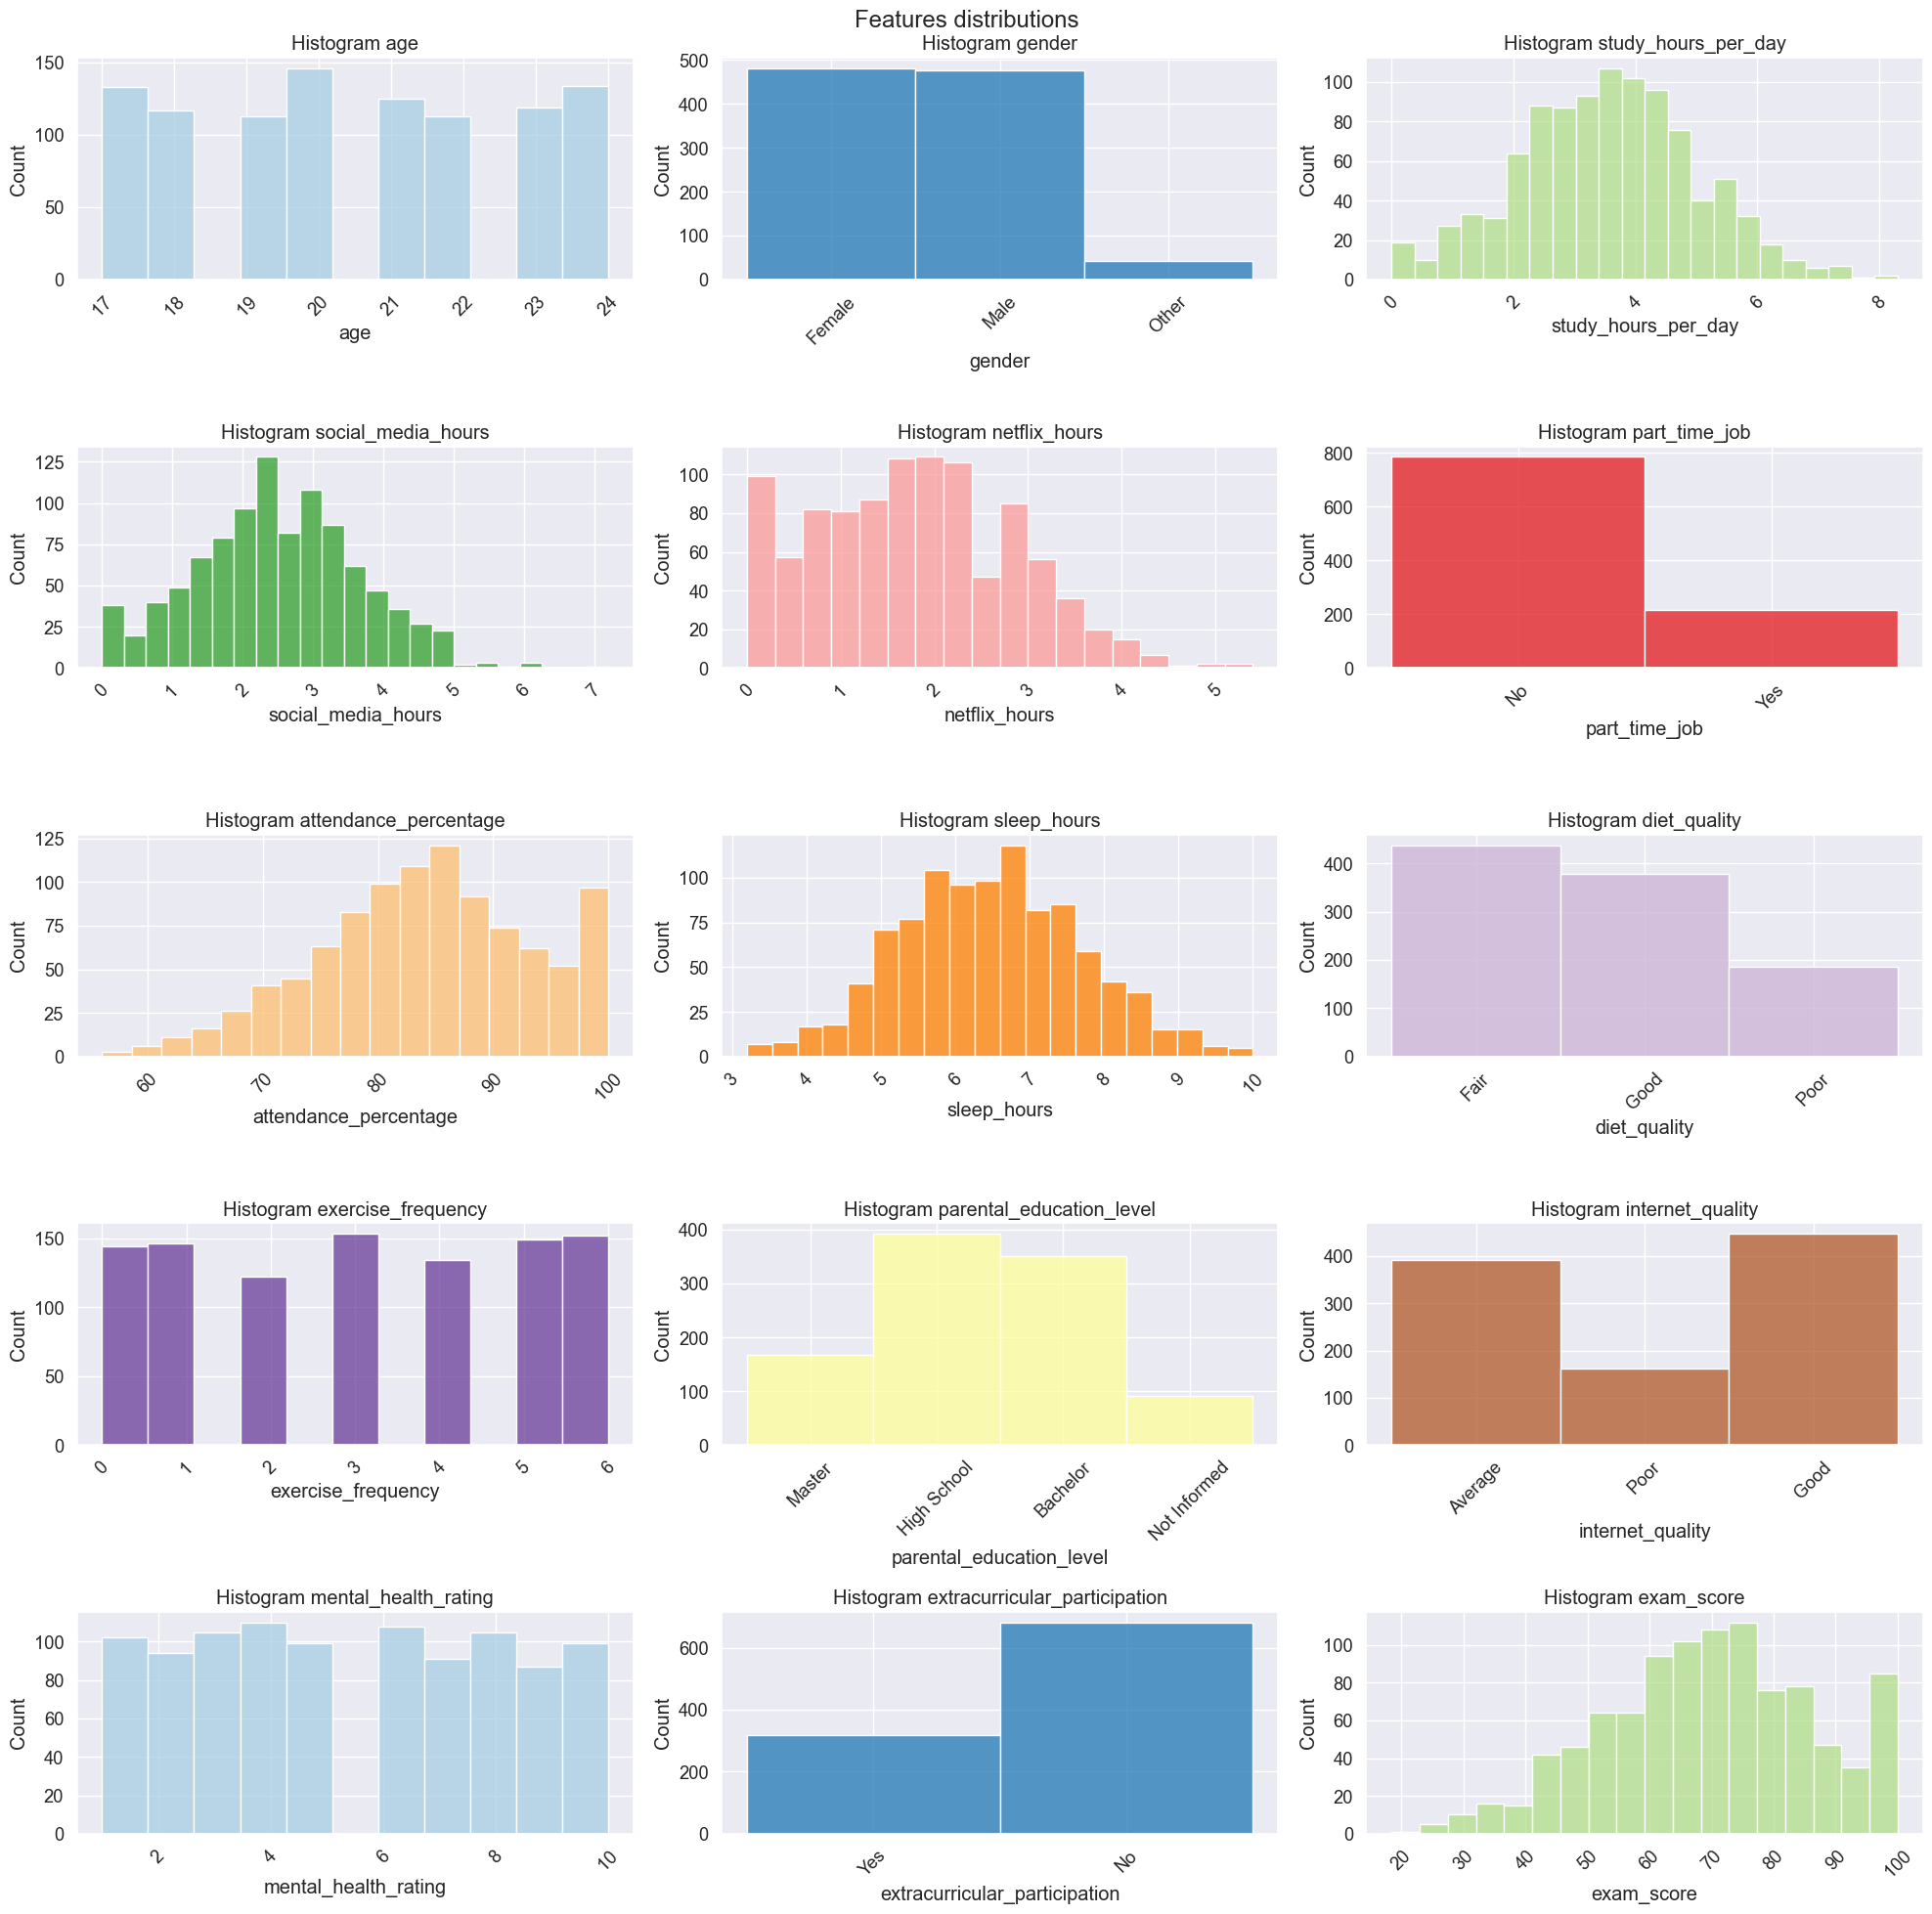

In [19]:
# Histogramas das features
dataframe_histograms(
    df_copy,
    color_dict=color_dict,
    nrows=5,
    ncols=3,
    figsize=(20, 20),
)

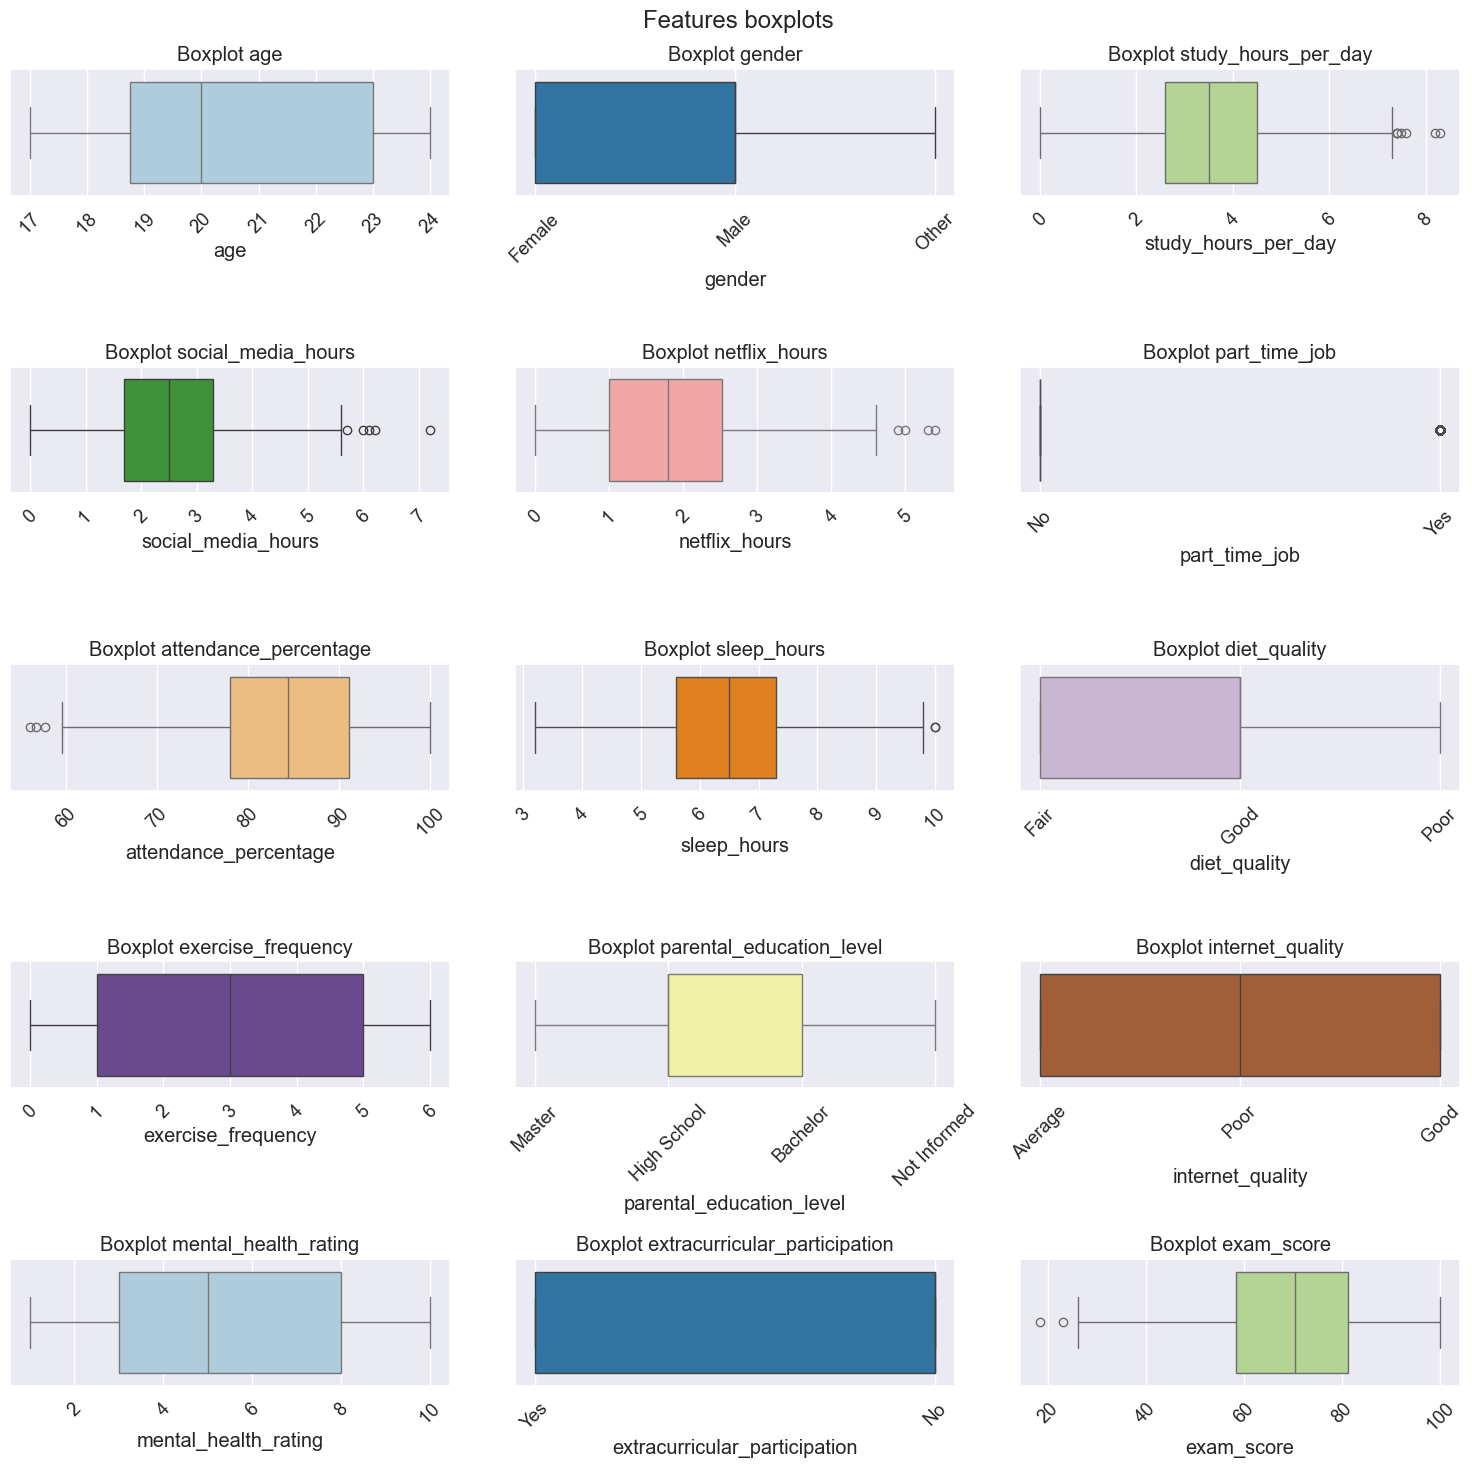

In [20]:
# Boxplots
dataframe_boxplots(
    df_copy,
    color_dict=color_dict,
    nrows=5,
    ncols=3,
    figsize=(15, 15),
)

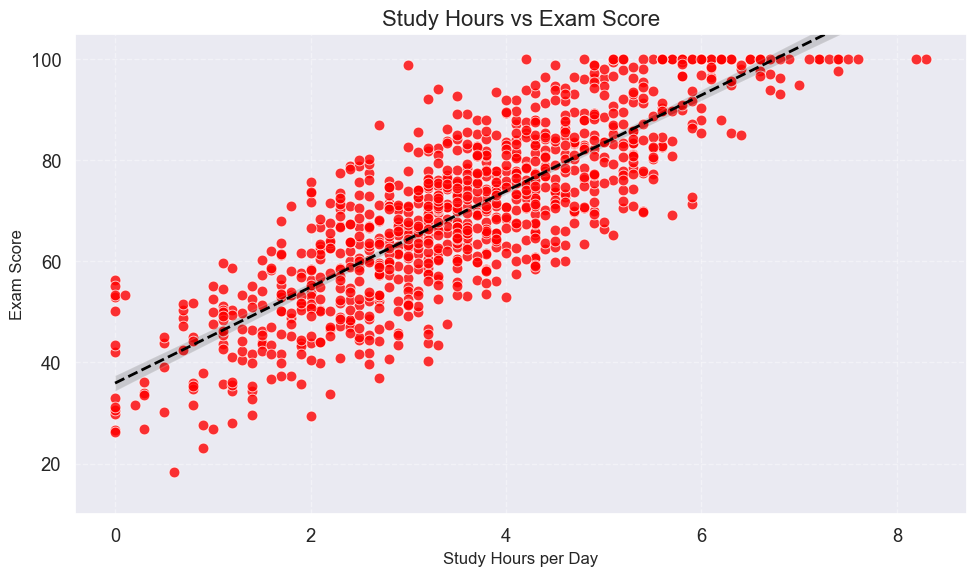

In [43]:
# Scatter plot horas de estudo x nota final
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df_copy,
    x='study_hours_per_day',
    y='exam_score',
    color='red',
    s=60,
    edgecolor='w',
    alpha=0.8,
)

sns.regplot(
    data=df_copy,
    x='study_hours_per_day',
    y='exam_score',
    scatter=False,
    color='black',
    line_kws={"linewidth": 2, "linestyle": "dashed"},
)
plt.ylim(10, 105)
plt.title('Study Hours vs Exam Score', fontsize=16)
plt.xlabel('Study Hours per Day', fontsize=12)
plt.ylabel('Exam Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Codificando dados

Foi criado um dataset codificado de modo a possibilitar o cálculo de correlação (feito na próxima seção).


In [22]:
# Criando nova cópia
encoded_df = df_copy.copy(deep=True)

In [23]:
# low_card_cols = ['part_time_job', 'extracurricular_participation']
encoded_df = pd.get_dummies(encoded_df, columns=cat_features, drop_first=True)

encoded_df.head()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score,gender_Male,gender_Other,part_time_job_Yes,diet_quality_Good,diet_quality_Poor,parental_education_level_High School,parental_education_level_Master,parental_education_level_Not Informed,internet_quality_Good,internet_quality_Poor,extracurricular_participation_Yes
0,23,0.0,1.2,1.1,85.0,8.0,6,8,56.2,False,False,False,False,False,False,True,False,False,False,True
1,20,6.9,2.8,2.3,97.3,4.6,6,8,100.0,False,False,False,True,False,True,False,False,False,False,False
2,21,1.4,3.1,1.3,94.8,8.0,1,1,34.3,True,False,False,False,True,True,False,False,False,True,False
3,23,1.0,3.9,1.0,71.0,9.2,4,1,26.8,False,False,False,False,True,False,True,False,True,False,True
4,19,5.0,4.4,0.5,90.9,4.9,3,1,66.4,False,False,False,False,False,False,True,False,True,False,False


### Correlação


In [24]:
# Calculando correlação
correlation_df = encoded_df.corr()
correlation_df

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score,gender_Male,gender_Other,part_time_job_Yes,diet_quality_Good,diet_quality_Poor,parental_education_level_High School,parental_education_level_Master,parental_education_level_Not Informed,internet_quality_Good,internet_quality_Poor,extracurricular_participation_Yes
age,1.000000,0.003971,-0.009151,-0.001174,-0.026055,0.037482,-0.003836,-0.045101,-0.008907,0.025562,0.015309,-0.011680,-0.002006,-0.010192,-0.046363,-0.004842,0.031171,0.029987,0.025087,-0.004993
study_hours_per_day,0.003971,1.000000,0.020282,-0.031158,0.026264,-0.027757,-0.028701,-0.003768,0.825419,-0.025634,0.008814,-0.029133,-0.003565,-0.066777,0.000643,0.009009,0.024490,0.001514,-0.026465,-0.003264
social_media_hours,-0.009151,0.020282,1.000000,0.011477,0.040479,0.018236,-0.037319,0.001496,-0.166733,-0.004995,0.015609,0.021224,0.026084,0.011390,0.028569,0.007508,0.002372,0.046071,-0.010402,-0.018597
netflix_hours,-0.001174,-0.031158,0.011477,1.000000,-0.002092,-0.000935,-0.006448,0.008034,-0.171779,0.000937,0.046266,0.009207,0.002406,0.021463,0.026835,-0.007959,-0.031362,0.030498,-0.036854,-0.005125
attendance_percentage,-0.026055,0.026264,0.040479,-0.002092,1.000000,0.013756,-0.007857,-0.018745,0.089836,-0.024108,-0.001184,-0.041771,-0.061024,0.033262,-0.026410,-0.072545,0.084574,-0.021596,0.049536,-0.017778
sleep_hours,0.037482,-0.027757,0.018236,-0.000935,0.013756,1.000000,0.019769,-0.006508,0.121683,-0.024235,0.057166,0.001645,-0.024224,0.034733,-0.021355,0.001298,-0.010152,-0.002190,-0.006988,0.027693
exercise_frequency,-0.003836,-0.028701,-0.037319,-0.006448,-0.007857,0.019769,1.000000,-0.000242,0.160107,0.068207,-0.009269,-0.021679,0.024576,0.020647,0.029885,-0.039751,-0.015152,-0.030575,0.027076,-0.005681
mental_health_rating,-0.045101,-0.003768,0.001496,0.008034,-0.018745,-0.006508,-0.000242,1.000000,0.321523,-0.006279,0.002810,0.013539,0.056837,0.019880,0.011014,-0.087748,-0.031590,-0.056385,0.019114,-0.004741
exam_score,-0.008907,0.825419,-0.166733,-0.171779,0.089836,0.121683,0.160107,0.321523,1.000000,-0.013191,0.012976,-0.026608,-0.010857,-0.041602,-0.002583,-0.040177,0.008108,-0.050804,0.003016,0.000881
gender_Male,0.025562,-0.025634,-0.004995,0.000937,-0.024108,-0.024235,0.068207,-0.006279,-0.013191,1.000000,-0.199963,0.031409,0.019382,-0.027044,0.028773,0.007198,-0.044601,-0.033097,0.074586,-0.007248


netflix_hours                           -0.171779
social_media_hours                      -0.166733
internet_quality_Good                   -0.050804
diet_quality_Poor                       -0.041602
parental_education_level_Master         -0.040177
part_time_job_Yes                       -0.026608
gender_Male                             -0.013191
diet_quality_Good                       -0.010857
age                                     -0.008907
parental_education_level_High School    -0.002583
extracurricular_participation_Yes        0.000881
internet_quality_Poor                    0.003016
parental_education_level_Not Informed    0.008108
gender_Other                             0.012976
attendance_percentage                    0.089836
sleep_hours                              0.121683
exercise_frequency                       0.160107
mental_health_rating                     0.321523
study_hours_per_day                      0.825419
Name: exam_score, dtype: float64


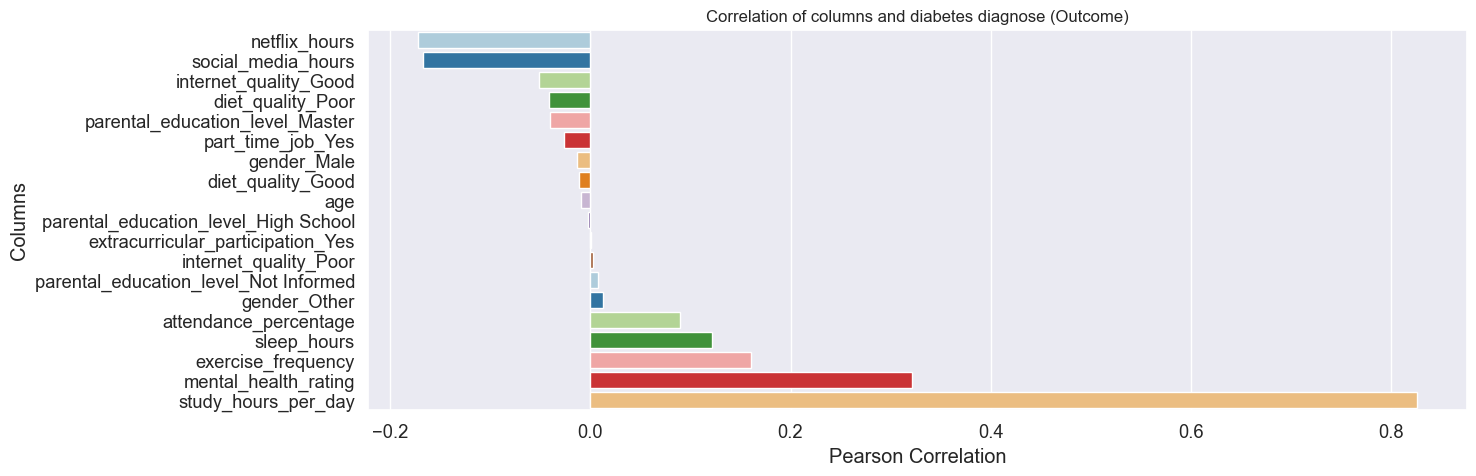

In [26]:
# Obtendo coluna de correlação
corr_income = correlation_df['exam_score'].sort_values().drop('exam_score')

print(corr_income)

# Criando plot
plot_correlation(corr_income, figsize=(15, 5))

gender_Male -0.013191
diet_quality_Good -0.010857
age -0.008907
parental_education_level_High School -0.002583
extracurricular_participation_No -0.000881
extracurricular_participation_Yes 0.000881
internet_quality_Poor 0.003016
gender_Female 0.007977
parental_education_level_Not Informed 0.008108
gender_Other 0.012976
part_time_job_No 0.026608
parental_education_level_Bachelor 0.029172


### Organizando dados de treinamento


In [27]:
# Separando dados em features e label ('exam_score')
X = df_copy.drop('exam_score', axis=1)
y = df_copy['exam_score']

## Implementação de K-Means from scratch

Explicar um pouco sobre o funcionamento do algoritmo

### K-means

[video link](https://www.youtube.com/watch?v=5w5iUbTlpMQ)

K-Means is an unsupervised machine learning algorithm, used to find patterns in the data. The fact that this is an unsupervised algorithm, means that k-means doesn't try to predict something, instead we're feeding data into the algorithm and trying to get patterns from that data. It is an iterative algorithm, meaning that we go through a multitude of iterations in the data to update the it, and get to the final cluster assignments.

To run a k-means clustering algorithm:

1. Specify the number of clusters you want (usually referred to as `k`).
2. Randomly initialize the `centroid` for each cluster. The centroid is the datapoint that is in the center of the cluster.
3. Determine which data points belong to which cluster by finding the closest `centroid` to each datapoint.
4. Update the centroids based on the geometric mean of all the data points in the cluster.
5. Run 3 and 4 until the `centroids` stop changing. Each run is referred to as an iteration.


In [28]:
# Implementação de K-Means
class KMeansClustering(BaseEstimator, ClusterMixin):
    def __init__(
        self,
        k: int = 3,
        max_iter: int = 200,
        conv_thresh: float = 1e-4,
        random_state: int = None,
    ) -> None:
        self.k = k
        self.max_iter = max_iter
        self.conv_thresh = conv_thresh
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None

    @staticmethod
    def euclidean_distance(data_point, centroids):
        return np.sqrt(np.sum(np.square(centroids - data_point), axis=1))

    def fit(self, X: np.ndarray | pd.DataFrame) -> 'KMeansClustering':
        X = X.values if isinstance(X, pd.DataFrame) else X

        if self.random_state != None:
            np.random.seed(self.random_state)
        self.centroids = np.random.uniform(
            low=np.amin(X, axis=0),
            high=np.amax(X, axis=0),
            size=(
                self.k,
                X.shape[1],
            ),
        )

        for _ in range(self.max_iter):
            y = []
            cluster_indices = []
            cluster_centers = []

            for data_point in X:
                distances = self.euclidean_distance(
                    data_point=data_point,
                    centroids=self.centroids,
                )
                cluster_num = np.argmin(distances)
                y.append(cluster_num)

            y = np.array(y)
            self.labels_ = y

            for i in range(self.k):
                cluster_indices.append(np.argwhere(y == i))

            for i, indices in enumerate(cluster_indices):
                if len(indices) == 0:
                    cluster_centers.append(self.centroids[i])
                else:
                    cluster_centers.append(np.mean(X[indices], axis=0)[0])

            new_centroids = np.array(cluster_centers)

            if np.max(self.centroids - new_centroids) < 1e-4:
                break

            self.centroids = new_centroids

        return self

    def predict(self, X: np.ndarray | pd.DataFrame) -> np.ndarray:

        X = X.values if isinstance(X, pd.DataFrame) else X

        predictions = []
        for data_point in X:
            distances = self.euclidean_distance(data_point, self.centroids)
            predictions.append(np.argmin(distances))
        return np.array(predictions)

    def fit_predict(
        self, X: np.ndarray | pd.DataFrame, y: np.ndarray | pd.DataFrame
    ) -> np.ndarray:
        self.fit(X)
        return self.labels_

    def transform(self, X: np.ndarray | pd.DataFrame) -> np.ndarray:

        X = X.values if isinstance(X, pd.DataFrame) else X

        distances = np.array([self.euclidean_distance(x, self.centroids) for x in X])
        return distances

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def score(
        self, X: np.ndarray | pd.DataFrame, y: np.ndarray | pd.DataFrame = None
    ) -> float:

        X = X.values if isinstance(X, pd.DataFrame) else X

        distances = self.transform(X)
        min_distances = np.min(distances, axis=1)
        unsupervised_score = -np.sum(np.square(min_distances))

        if y is not None:
            predicted_labels = self.predict(X)
            supervised_score = adjusted_rand_score(y, predicted_labels)
            return supervised_score

        return unsupervised_score

## Justificativa do valor de $K$

Métodos para determinar K:

- Elbow Method (WCSS vs.K): procure o “cotovelo” na curva de soma de quadrados dentro do cluster [link](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/?utm_source=chatgpt.com)

- Silhouette Score: avalia coesão e separação dos clusters; valores mais altos indicam clusters bem definidos [link](https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/?utm_source=chatgpt.com)

- Gap Statistic: compara inércia do seu dataset com dataset de referência aleatório.


In [29]:
# Separando features em numéricas e categóricas
cat_features = df_copy.select_dtypes(include=['object']).columns.tolist()

num_features = (
    df_copy.select_dtypes(exclude=['object'])
    .drop('exam_score', axis=1)
    .columns.tolist()
)

In [30]:
# Criando Pipelines

# Pipeline categórica
cat_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='constant', fill_value='?')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False)),
    ]
)

# Pipeline numérica
num_pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),
    ]
)

# Definindo transformador de pré-processamento
preprocessor = ColumnTransformer(
    [
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features),
    ],
)

model = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=0.75)),
        ('kmeans', KMeansClustering(max_iter=500, conv_thresh=1e-5, random_state=42)),
    ]
)

In [ ]:
# Transformando dados
data = preprocessor.fit_transform(X)

In [32]:
# Definindo pca para teste de cotovelo
pca = PCA(0.6)
data_pca = pca.fit_transform(data)

In [33]:
pd.DataFrame(data_pca)

,0,1,2,3,4,5
0,-2.739648,0.474051,0.916796,1.224677,0.749673,-0.578613
1,1.504194,-1.135307,-0.685199,1.098671,-0.736853,2.559054
2,0.294390,1.873532,1.061903,0.345974,-0.473953,-1.897769
3,-1.651688,2.591852,0.979429,-0.046353,0.996199,-1.531967
4,2.131671,0.491927,-1.055209,0.644360,-0.937454,-0.699215
...,...,...,...,...,...,...
995,-1.444830,0.034089,-0.357435,-0.303078,0.518495,-0.562091
996,-0.069626,-1.147582,0.452489,-0.114179,-0.472472,-0.788321
997,-1.641357,-1.228712,-0.308949,-0.260976,1.581061,0.098503
998,2.328052,2.945657,-0.252198,-0.073321,0.139851,-0.140548


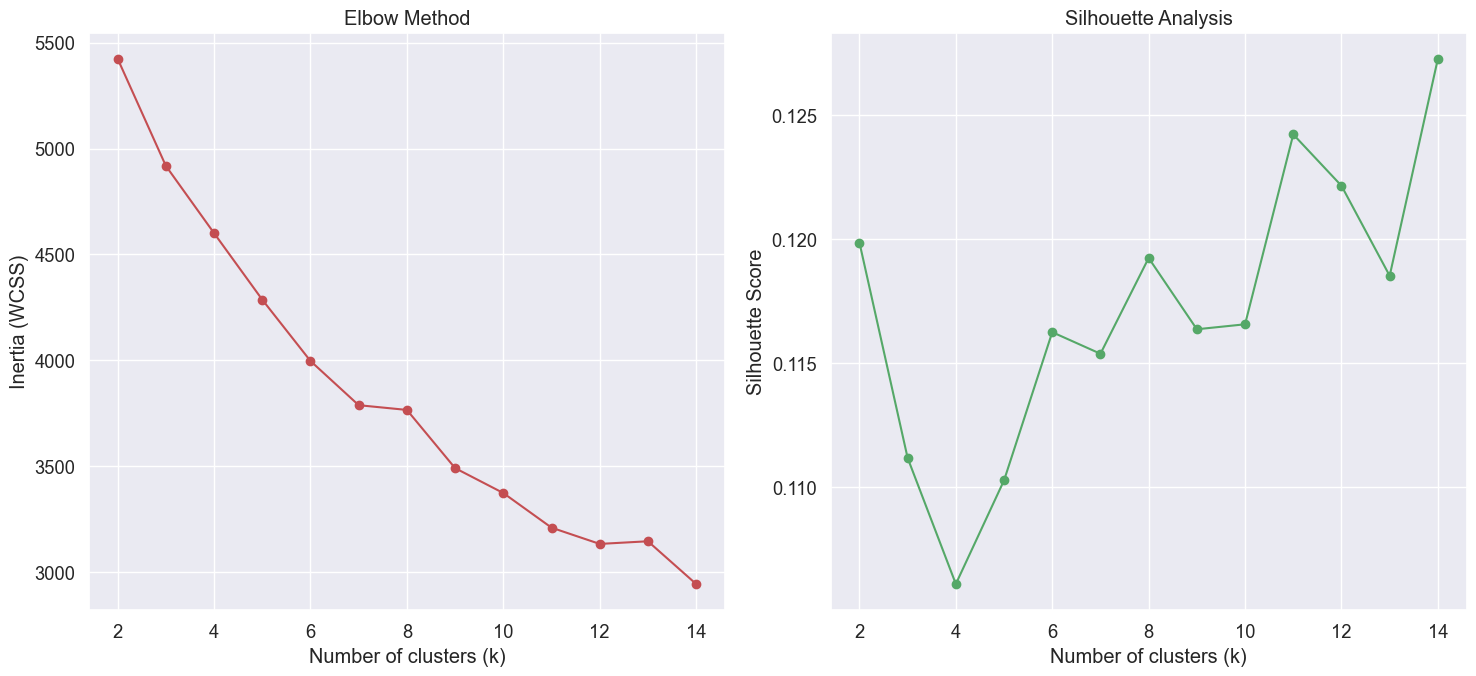

In [34]:
k_values = range(2, 15)
inertias = []
silhouette_scores = []

for k in k_values:
    test_kmeans = KMeansClustering(k=k, max_iter=1000)
    test_kmeans.fit(data_pca)

    inertia = -test_kmeans.score(data_pca)
    inertias.append(inertia)

    labels = test_kmeans.labels_
    if len(np.unique(labels)) > 1:
        silhouette = silhouette_score(data_pca, labels)
    else:
        silhouette = np.nan
    silhouette_scores.append(silhouette)


plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, 'ro-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method')
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, 'go-', scalex=True)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.grid(True)

plt.tight_layout()
plt.show()

In [35]:
# Usando k=7
model.set_params(**{'kmeans__k': 8, 'pca__n_components': 0.6})

labels = model.fit_predict(X)

## Análise crítica final


In [37]:
# Obtendo dataset groupby
mean_groupby_cluster = encoded_df.groupby(by='cluster').mean().sort_values('exam_score')

mean_groupby_cluster

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score,gender_Male,gender_Other,part_time_job_Yes,diet_quality_Good,diet_quality_Poor,parental_education_level_High School,parental_education_level_Master,parental_education_level_Not Informed,internet_quality_Good,internet_quality_Poor,extracurricular_participation_Yes
cluster,,,,,,,,,,,,,,,,,,,,
0,21.441441,2.713514,3.270270,1.522523,87.854054,7.391892,1.666667,2.972973,55.253153,0.459459,0.045045,0.189189,0.306306,0.162162,0.342342,0.225225,0.108108,0.486486,0.153153,0.288288
6,18.684932,2.584932,2.132192,2.520548,88.019178,5.982192,4.164384,4.417808,58.536986,0.506849,0.041096,0.178082,0.335616,0.239726,0.390411,0.164384,0.095890,0.431507,0.157534,0.315068
4,18.974138,2.674138,2.328448,0.762931,81.161207,6.443103,2.224138,6.913793,65.884483,0.474138,0.051724,0.232759,0.370690,0.189655,0.379310,0.155172,0.086207,0.353448,0.232759,0.387931
3,21.380531,3.541593,2.184071,2.284956,72.449558,5.885841,2.141593,7.699115,69.642478,0.477876,0.026549,0.238938,0.415929,0.150442,0.424779,0.194690,0.035398,0.433628,0.115044,0.345133
1,20.990099,3.339604,3.381188,2.826733,85.964356,7.399010,3.237624,7.772277,70.099010,0.425743,0.079208,0.227723,0.425743,0.247525,0.425743,0.089109,0.079208,0.514851,0.198020,0.336634
7,22.439189,3.646622,1.729730,1.613514,80.136486,6.660811,4.277027,3.554054,71.922973,0.540541,0.054054,0.209459,0.391892,0.189189,0.391892,0.175676,0.108108,0.466216,0.148649,0.297297
2,20.423611,4.779861,2.906944,1.857639,87.805556,5.640972,1.555556,4.048611,74.286806,0.416667,0.006944,0.270833,0.416667,0.138889,0.388889,0.208333,0.104167,0.534722,0.145833,0.298611
5,19.760331,4.923967,2.464463,1.191736,88.768595,6.762810,4.669421,7.413223,90.809091,0.495868,0.041322,0.173554,0.363636,0.165289,0.396694,0.107438,0.099174,0.347107,0.157025,0.289256


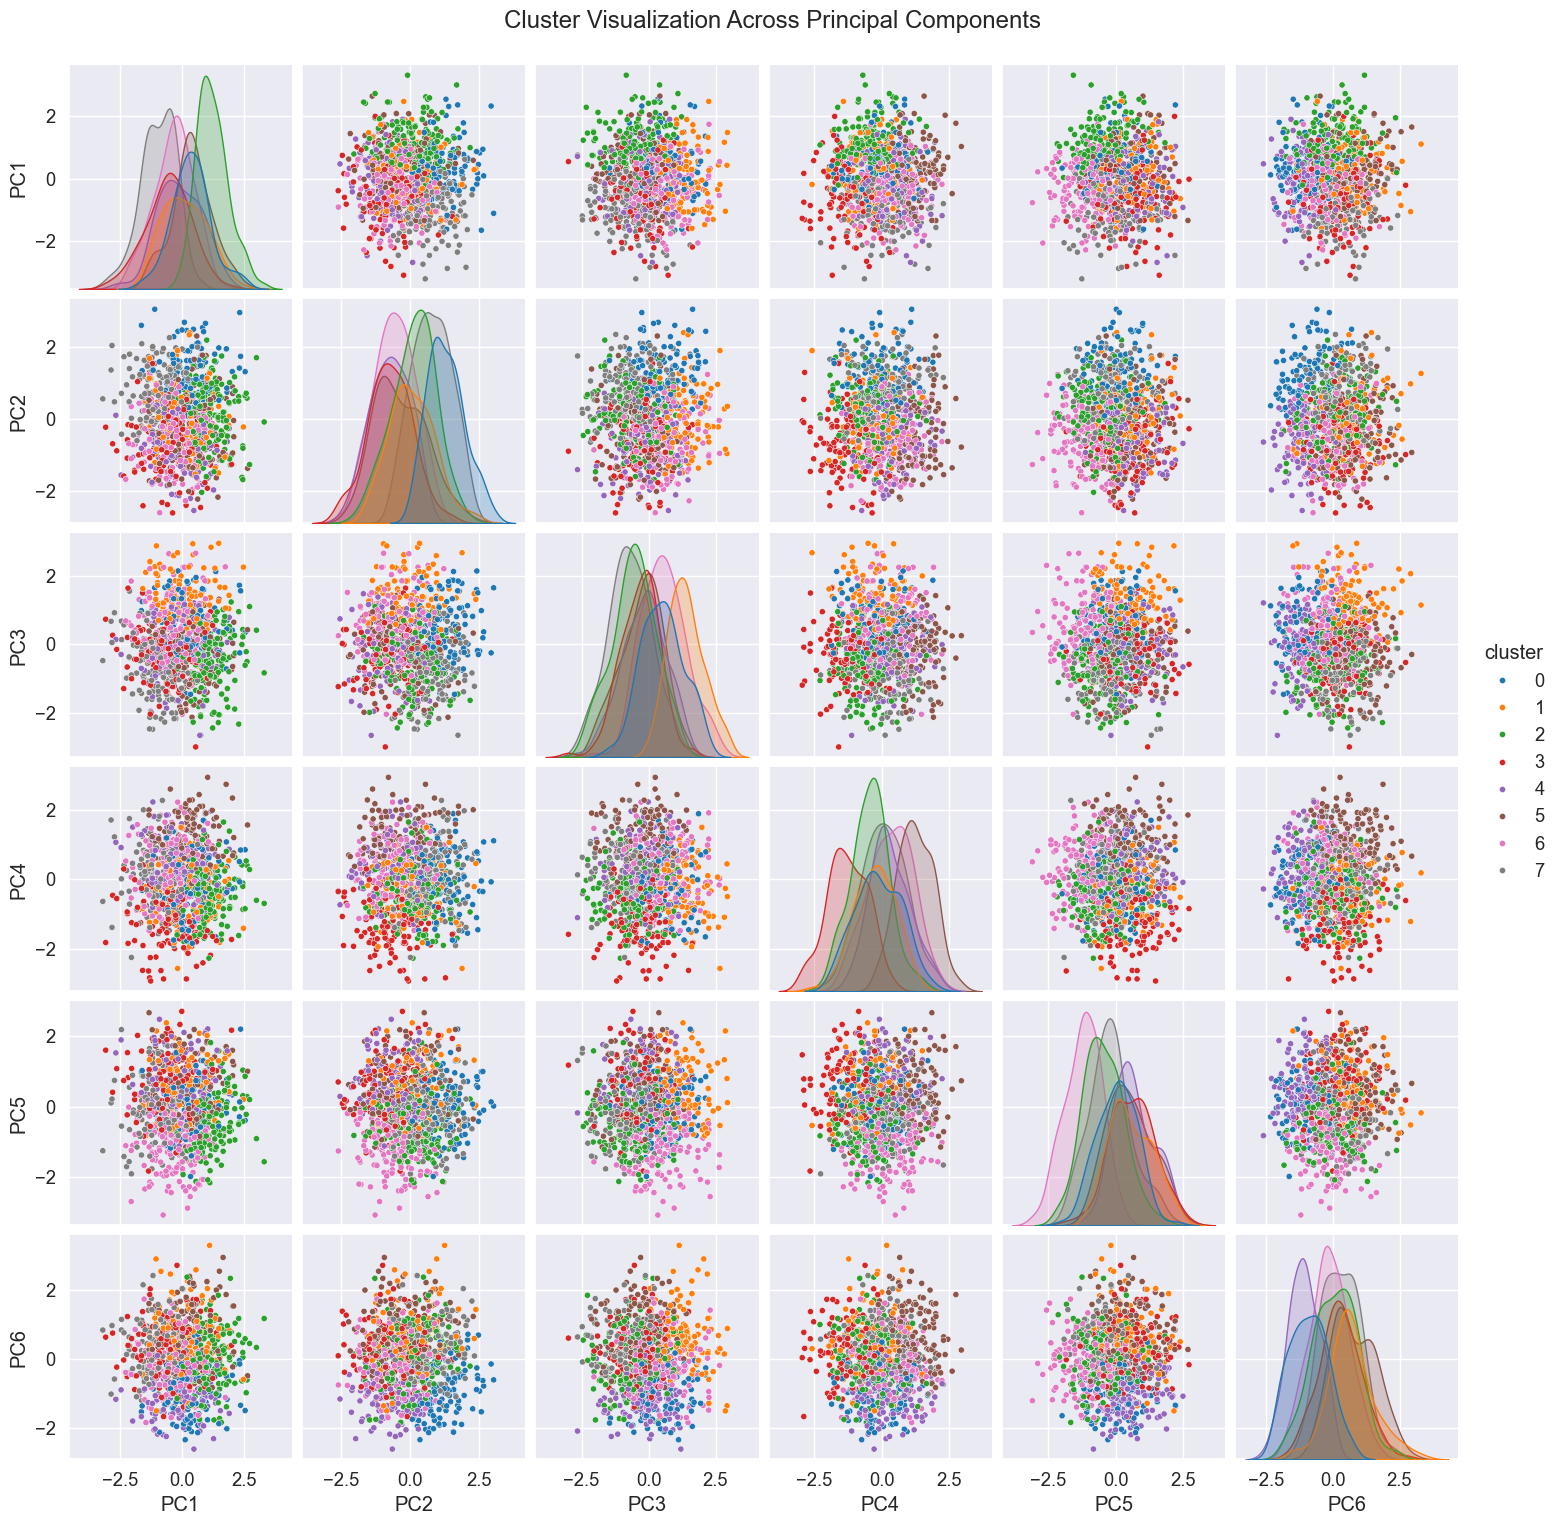

<Figure size 640x480 with 0 Axes>

In [36]:
# Convert PCA data to DataFrame
df_pca = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(data_pca.shape[1])])
df_pca['cluster'] = labels
encoded_df['cluster'] = labels

sns.pairplot(
    df_pca,
    vars=df_pca.columns[:6],
    hue='cluster',
    palette='tab10',
    plot_kws={'s': 20},
)
plt.suptitle("Cluster Visualization Across Principal Components", y=1.02)
plt.show()

plt.suptitle("Cluster Visualization Across Principal Components", y=1.02)
plt.show()

## Salvando modelos


In [44]:
# Criando pasta de modelos
!mkdir ../modelos

In [ ]:
# Salvando modelo
pickle.dump(model, open('../modelos/modelo_clusterizacao.pkl', 'wb'))

## Tarefas Extra


### DBSCAN

https://www.geeksforgeeks.org/dbscan-clustering-in-ml-density-based-clustering/?utm_source=chatgpt.com

https://en.wikipedia.org/wiki/DBSCAN?utm_source=chatgpt.com


### Hierarchical Clustering

https://www.ibm.com/think/topics/hierarchical-clustering?utm_source=chatgpt.com

https://en.wikipedia.org/wiki/Hierarchical_clustering?utm_source=chatgpt.com


### SotA para Clustering

https://peerj.com/articles/cs-2286.pdf?utm_source=chatgpt.com

https://www.researchgate.net/publication/358814868_A_comprehensive_survey_of_clustering_algorithms_State-of-the-art_machine_learning_applications_taxonomy_challenges_and_future_research_prospects?utm_source=chatgpt.com

https://medium.com/%40sina.nazeri/comparing-the-state-of-the-art-clustering-algorithms-1e65a08157a1?utm_source=chatgpt.com
